# Importing Dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# K-Means Clustering Necessary Imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Random Forest Necessary Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

#make the plots show up inline
%matplotlib inline

In [2]:
# Representing data
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [4]:
X_iris = iris.drop('species', axis=1)
X_iris.shape

(150, 4)

In [5]:
y_iris = iris['species']
y_iris.shape
#iris

(150,)

In [6]:
y_iris

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object

In [7]:
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X_iris, y_iris, test_size=0.2)

In [8]:
rfclf_iris = RandomForestClassifier()
rfclf_iris.fit(X_train_iris, y_train_iris)

y_prediction_iris = rfclf_iris.predict(X_test_iris)

In [9]:
y_prediction_iris

array(['versicolor', 'virginica', 'virginica', 'virginica', 'virginica',
       'setosa', 'setosa', 'virginica', 'setosa', 'setosa', 'setosa',
       'virginica', 'versicolor', 'setosa', 'versicolor', 'virginica',
       'versicolor', 'setosa', 'virginica', 'setosa', 'versicolor',
       'versicolor', 'virginica', 'setosa', 'virginica', 'versicolor',
       'virginica', 'setosa', 'versicolor', 'versicolor'], dtype=object)

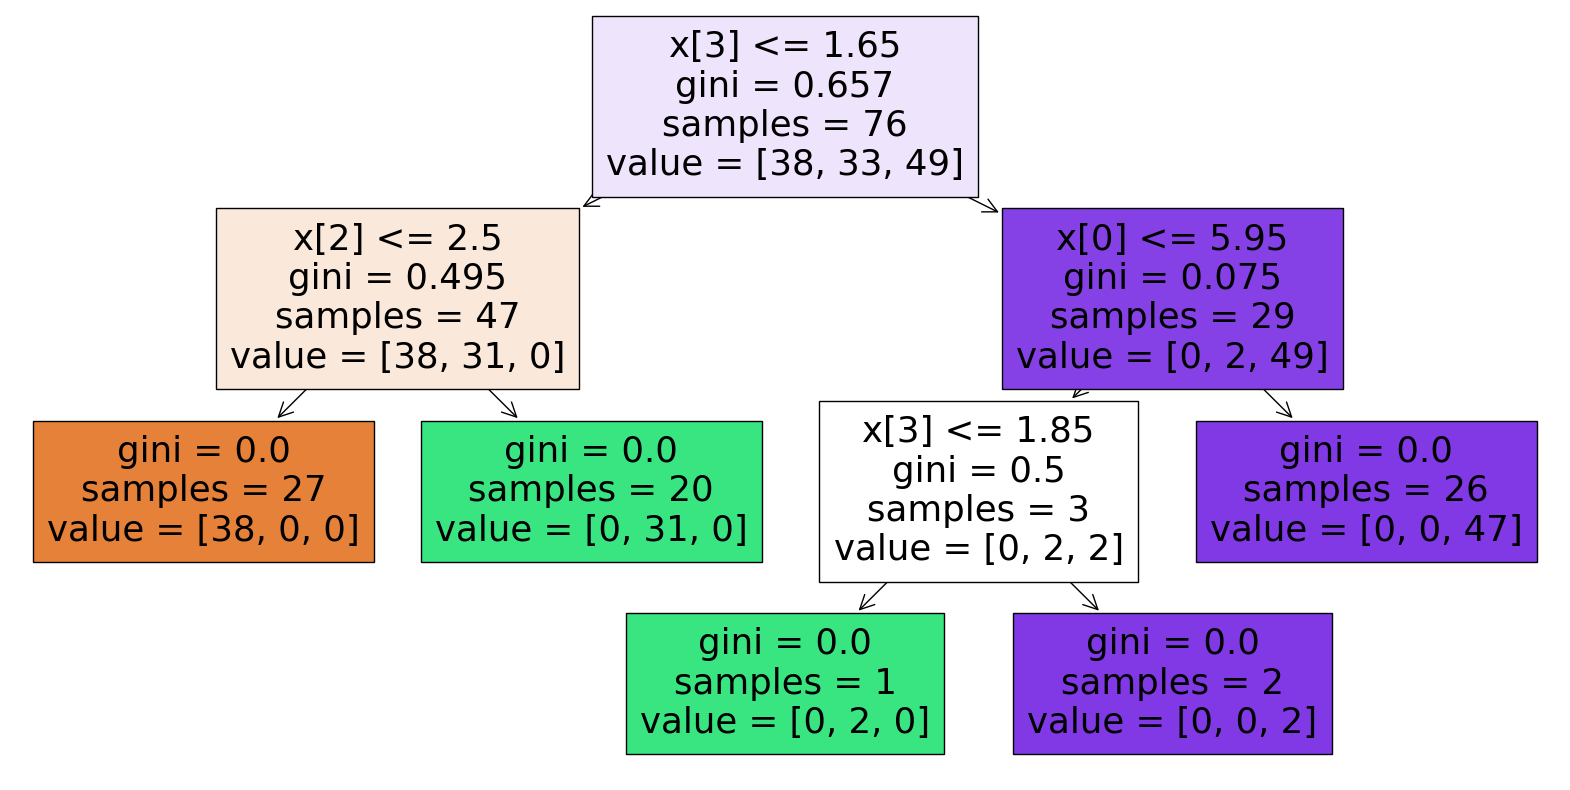

In [77]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(rfclf_iris.estimators_[1], filled=True)
plt.show()

In [39]:
from IPython.display import display, HTML

# Define the code as a string
code_str = '''
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(rfr.estimators_[0], filled=True)
plt.show()
'''

# Display the code inside a clickable box using HTML
display(HTML(f"<pre style='background-color: #f7f7f7; padding: 10px; border: 1px solid #ddd; font-family: monospace;'>{code_str}</pre>"))

In [41]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import ipywidgets as widgets
from IPython.display import display

# Generate the plot
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(rfclf_iris.estimators_[0], filled=True)

# Create an interactive widget
output = widgets.Output()

with output:
    # Show the plot
    plt.show()

# Display the interactive plot
display(output)

Output()

Box 1: Top-left (0.0, 1.0), Bottom-right (1.0, 0.0)


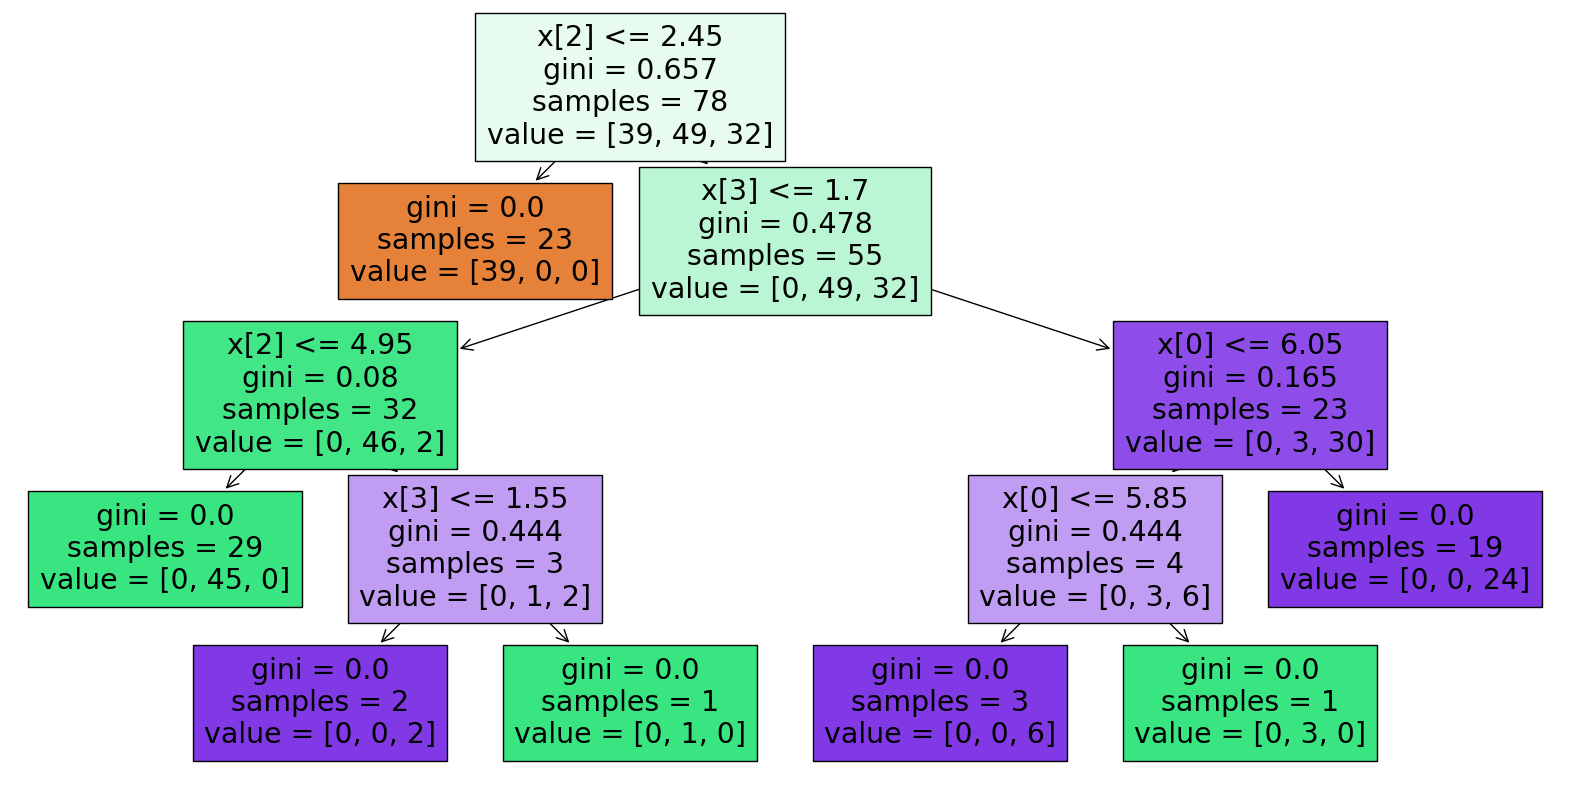

In [43]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Initialize the RandomForestRegressor (or DecisionTreeClassifier) and fit the data
# Assuming rfr.estimators_[0] is a decision tree (as in previous examples)

# Create an empty list to store the coordinates of each box
coordinates = []

# Generate the plot
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(rfclf_iris.estimators_[0], filled=True, ax=ax)

# Iterate over the plot elements to extract the box coordinates
for child in ax.get_children():
    if isinstance(child, plt.Rectangle):  # Look for Rectangle instances (boxes for nodes)
        # Extract the coordinates for the top-left and bottom-right
        x0 = child.get_x()  # x-coordinate of the bottom-left corner
        y0 = child.get_y()  # y-coordinate of the bottom-left corner
        width = child.get_width()
        height = child.get_height()

        # Top-left and bottom-right coordinates
        top_left = (x0, y0 + height)   # y0 + height gives the top left corner
        bottom_right = (x0 + width, y0)  # x0 + width gives the bottom-right corner

        # Store the coordinates in the list
        coordinates.append({'top_left': top_left, 'bottom_right': bottom_right})

# Print the coordinates
for i, coord in enumerate(coordinates):
    print(f"Box {i+1}: Top-left {coord['top_left']}, Bottom-right {coord['bottom_right']}")

plt.show()

In [45]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn.tree import plot_tree
from IPython.display import display

# Create a random forest tree plot (assumed to have 'rfr' already fitted)
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(rfclf_iris.estimators_[0], filled=True, ax=ax)

# Create an interactive widget for displaying the plot
output = widgets.Output()

with output:
    plt.show()

# Display the output in a resizable scrollable area
interactive_window = widgets.VBox([output], layout=widgets.Layout(height='500px', width='800px', border='solid 1px gray'))

# Display the interactive window
display(interactive_window)

In [46]:
import plotly.graph_objects as go
import numpy as np
from ipywidgets import widgets
from IPython.display import display

# Create random data for the plot
x = np.random.rand(100)
y = np.random.rand(100)

# Initialize the red dot trace with a single point (initially off the chart)
red_dot = go.Scatter(
    x=[None],
    y=[None],
    mode='markers',
    marker=dict(size=10, color='red'),
    name='Hover Dot'
)

# Create a Plotly scatter plot
fig = go.Figure()

# Add the scatter plot data points
fig.add_trace(go.Scatter(x=x, y=y, mode='markers', marker=dict(size=12, color='LightSkyBlue', line=dict(width=2))))

# Add the red dot trace
fig.add_trace(red_dot)

# Update layout for better visualization
fig.update_layout(title="Interactive Plotly Window with Hover Dot", xaxis_title="X Axis", yaxis_title="Y Axis")

# -----------------------------
# JavaScript code to move the red dot based on hover event
# -----------------------------
fig.update_layout(
    hovermode='closest',  # Enable closest point hover interaction
    # Inject custom JavaScript to update the red dot position
    hoverlabel=dict(bgcolor='white'),
    template="plotly_white"
)

# Add JavaScript callback using fig.show with embed in JupyterLab
config = dict({'scrollZoom': True})

# Create the Plotly plot widget
plotly_output = widgets.Output()

with plotly_output:
    fig.show(config=config)

# Display the interactive window with the plot
interactive_window = widgets.VBox([plotly_output], layout=widgets.Layout(height='600px', width='800px', border='solid 1px gray'))

display(interactive_window)

In [52]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn.tree import plot_tree
from IPython.display import display

# Create a random forest tree plot (assumed to have 'rfr' already fitted)
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(rfclf_iris.estimators_[0], filled=True, ax=ax)

# Create an interactive widget for displaying the plot
output = widgets.Output()

# Initialize a list to store clicked coordinates
clicked_coordinates = []

# Define the click event handler
def on_click(event):
    if event.xdata is not None and event.ydata is not None:  # Ensure the click is within the plot area
        coord = (event.xdata, event.ydata)
        clicked_coordinates.append(coord)  # Store the coordinates
        print(f"Clicked coordinates: {coord}")  # Print the coordinates

# Connect the click event to the handler
cid = fig.canvas.mpl_connect('button_press_event', on_click)

with output:
    plt.show()

# Display the output in a resizable scrollable area
interactive_window = widgets.VBox([output], layout=widgets.Layout(height='500px', width='800px', border='solid 1px gray'))

# Display the interactive window
display(interactive_window)

# At any point, you can check the clicked_coordinates list
print(clicked_coordinates)  # Uncomment to see the stored coordinates

[]


In [54]:
print(clicked_coordinates)

[]


In [10]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn.tree import plot_tree
from IPython.display import display

# Create a random forest tree plot (assumed to have 'rfr' already fitted)
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(rfclf_iris.estimators_[0], filled=True, ax=ax)

# Create an interactive widget for displaying the plot
output = widgets.Output()

# Initialize a list to store clicked coordinates
clicked_coordinates = []

# Initialize a larger red dot for tracking mouse position (radius ~ 25 pixels)
red_dot, = ax.plot([], [], 'ro', markersize=25, alpha=0.7)  # Red dot with size 25 and slight transparency

# Define the click event handler
def on_click(event):
    if event.xdata is not None and event.ydata is not None:  # Ensure the click is within the plot area
        coord = (event.xdata, event.ydata)
        clicked_coordinates.append(coord)  # Store the coordinates
        print(f"Clicked coordinates: {coord}")  # Print the coordinates

# Define the mouse motion event handler
def on_move(event):
    if event.xdata is not None and event.ydata is not None:  # Ensure the mouse is within the plot area
        # Update the red dot's position
        red_dot.set_data(event.xdata, event.ydata)
        fig.canvas.draw_idle()  # Redraw the figure to update the dot's position

# Connect the click event to the handler
cid_click = fig.canvas.mpl_connect('button_press_event', on_click)
cid_move = fig.canvas.mpl_connect('motion_notify_event', on_move)

# Set initial limits to ensure the red dot is visible (optional, adjust as needed)
ax.set_xlim(-0.5, 0.5)  # Adjust based on your data's expected range
ax.set_ylim(-0.5, 0.5)  # Adjust based on your data's expected range

with output:
    plt.show()

# Display the output in a resizable scrollable area
interactive_window = widgets.VBox([output], layout=widgets.Layout(height='500px', width='800px', border='solid 1px gray'))

# Display the interactive window
display(interactive_window)

# At any point, you can check the clicked_coordinates list
# print(clicked_coordinates)  # Uncomment to see the stored coordinates


In [11]:
print(clicked_coordinates)

[]


In [14]:
import plotly.graph_objects as go

# Create a blank figure
fig = go.Figure()

# Add a layout to make it more visually appealing (optional)
fig.update_layout(
    title='Blank Image',
    xaxis_title='X Axis',
    yaxis_title='Y Axis',
    showlegend=False,
    width=800,
    height=600,
    paper_bgcolor='white',  # Set background color to white
)

# Hide the axes
fig.update_xaxes(visible=False)  # Hide x-axis
fig.update_yaxes(visible=False)  # Hide y-axis

# Show the figure
fig.show()

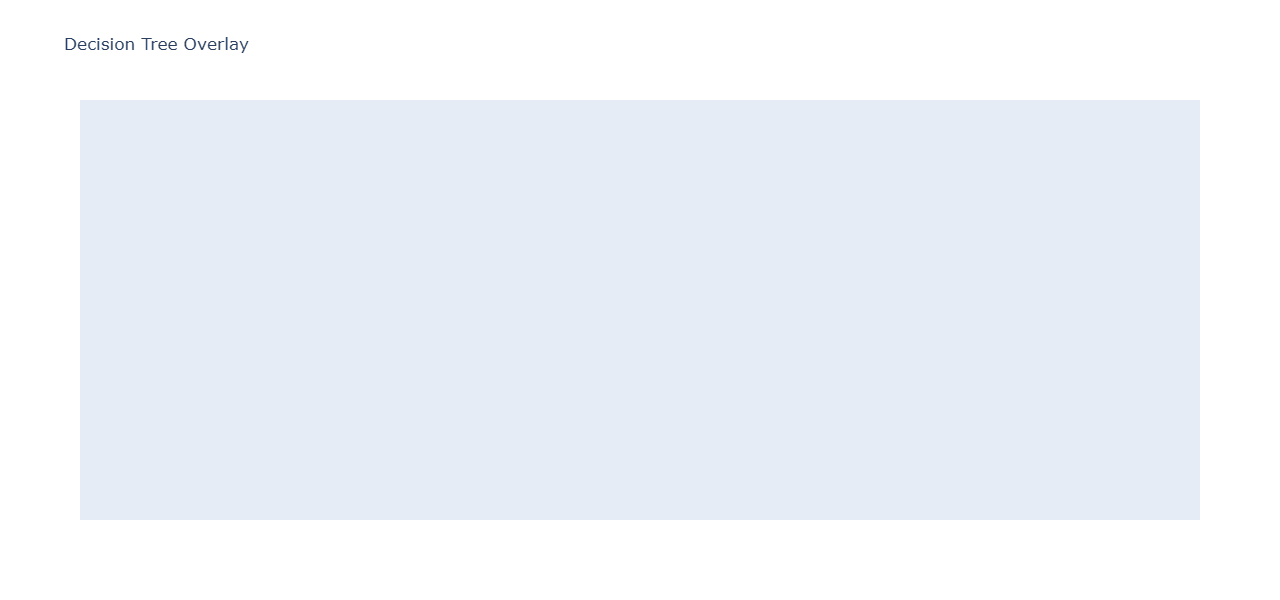

In [17]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import plotly.graph_objects as go

# Assume rfr is a fitted Random Forest model
# Create a Matplotlib figure for the decision tree
plt.figure(figsize=(20, 10))
plot_tree(rfclf_iris.estimators_[0], filled=True)
# Save the figure as an image file
plt.savefig('decision_tree.png')  # Save the plot as a PNG file
plt.close()  # Close the Matplotlib figure

# Create a blank figure
fig = go.Figure()

# Add a layout to make it more visually appealing (optional)
fig.update_layout(
    title='Decision Tree Overlay',
    width=800,
    height=600,
    paper_bgcolor='white',  # Set background color to white
)

# Hide the axes
fig.update_xaxes(visible=False)  # Hide x-axis
fig.update_yaxes(visible=False)  # Hide y-axis

# Add the saved decision tree image to the Plotly figure
fig.add_layout_image(
    dict(
        source='decision_tree.png',  # Path to the saved image
        x=0.5,  # X position in the plot area (0 to 1)
        y=0.5,  # Y position in the plot area (0 to 1)
        xref='paper',  # Reference system for x (paper coordinates)
        yref='paper',  # Reference system for y (paper coordinates)
        sizex=0.9,  # Width of the image in paper coordinates
        sizey=0.9,  # Height of the image in paper coordinates
        xanchor='center',  # Anchor the image at the center
        yanchor='middle'  # Anchor the image at the middle
    )
)

# Show the figure
fig.show()

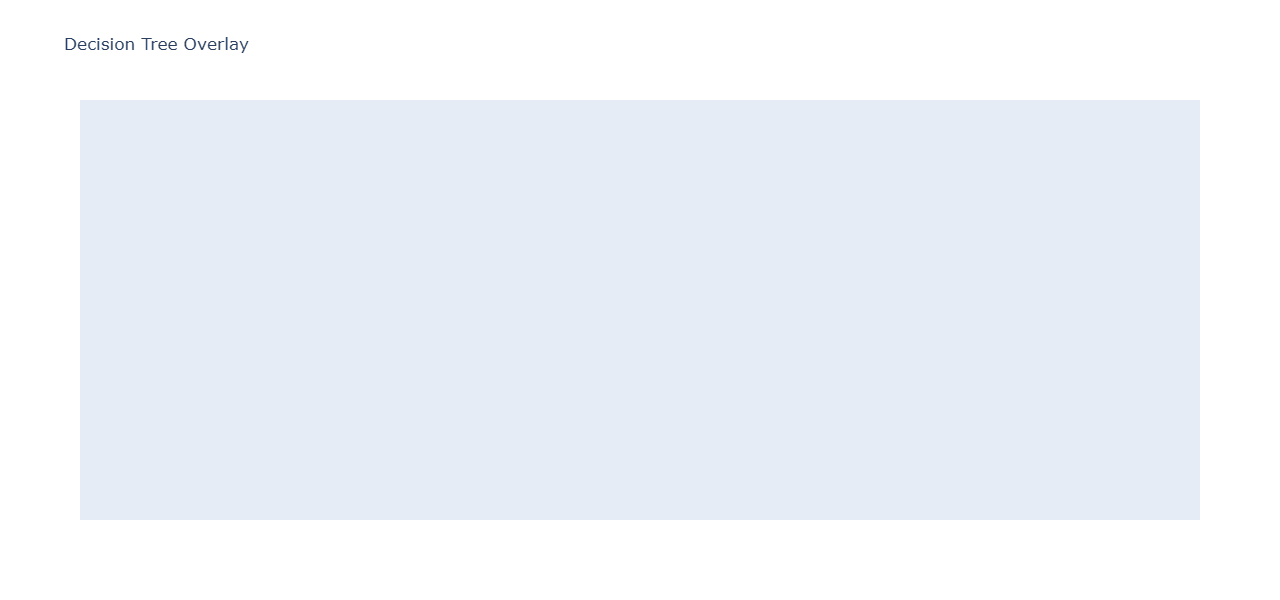

In [18]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import plotly.graph_objects as go

# Assume rfr is a fitted Random Forest model
# Create a Matplotlib figure for the decision tree
plt.figure(figsize=(20, 10))
plot_tree(rfclf_iris.estimators_[0], filled=True)
# Save the figure as an image file
plt.savefig('decision_tree.png')  # Save the plot as a PNG file
plt.close()  # Close the Matplotlib figure

# Create a blank figure
fig = go.Figure()

# Add a layout to make it more visually appealing (optional)
fig.update_layout(
    title='Decision Tree Overlay',
    width=800,
    height=600,
    paper_bgcolor='white',  # Set background color to white
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        visible=False,  # Hide x-axis
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        visible=False,  # Hide y-axis
    ),
    dragmode='zoom'  # Enable zooming
)

# Add the saved decision tree image to the Plotly figure
fig.add_layout_image(
    dict(
        source='decision_tree.png',  # Path to the saved image
        x=0.5,  # X position in the plot area (0 to 1)
        y=0.5,  # Y position in the plot area (0 to 1)
        xref='paper',  # Reference system for x (paper coordinates)
        yref='paper',  # Reference system for y (paper coordinates)
        sizex=0.9,  # Width of the image in paper coordinates
        sizey=0.9,  # Height of the image in paper coordinates
        xanchor='center',  # Anchor the image at the center
        yanchor='middle'  # Anchor the image at the middle
    )
)

# Show the figure
fig.show()


In [21]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Assume rfr is a fitted Random Forest model
# Create a Matplotlib figure for the decision tree
plt.figure(figsize=(20, 10))
plot_tree(rfr.estimators_[0], filled=True)
# Save the figure as an image file
plt.savefig('decision_tree.png')  # Save the plot as a PNG file
plt.close()  # Close the Matplotlib figure

# Initialize the Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    html.H1("Decision Tree Visualization"),
    dcc.Graph(
        id='decision-tree-graph',
        figure={
            'data': [],
            'layout': {
                'images': [
                    {
                        'source': 'decision_tree.png',
                        'xref': 'paper',
                        'yref': 'paper',
                        'x': 0,
                        'y': 1,
                        'sizex': 2,  # Set the initial size of the image
                        'sizey': 1.5,
                        'xanchor': 'center',
                        'yanchor': 'middle',
                        'opacity': 1,
                        'layer': 'below'
                    }
                ],
                'dragmode': 'zoom',
                'xaxis': {
                    'visible': False,
                    'range': [0, 2],  # Set the range for x-axis
                },
                'yaxis': {
                    'visible': False,
                    'range': [0, 1.5],  # Set the range for y-axis
                },
                'paper_bgcolor': 'white',
            }
        },
        config={'scrollZoom': True}  # Enable scroll zoom
    )
])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


ImportError: cannot import name '_urlencode' from 'werkzeug.urls' (C:\Users\adamr\anaconda3\lib\site-packages\werkzeug\urls.py)

In [22]:
# Run this app with `python app.py` and
# visit http://127.0.0.1:8050/ in your web browser.


from dash import Dash, dcc, html
import plotly.express as px
import pandas as pd

app = Dash(__name__)

colors = {
    'background': '#111111',
    'text': '#7FDBFF'
}

# assume you have a "long-form" data frame
# see https://plotly.com/python/px-arguments/ for more options
df = pd.DataFrame({
    "Fruit": ["Apples", "Oranges", "Bananas", "Apples", "Oranges", "Bananas"],
    "Amount": [4, 1, 2, 2, 4, 5],
    "City": ["SF", "SF", "SF", "Montreal", "Montreal", "Montreal"]
})

fig = px.bar(df, x="Fruit", y="Amount", color="City", barmode="group")

fig.update_layout(
    plot_bgcolor=colors['background'],
    paper_bgcolor=colors['background'],
    font_color=colors['text']
)

app.layout = html.Div(style={'backgroundColor': colors['background']}, children=[
    html.H1(
        children='Hello Dash',
        style={
            'textAlign': 'center',
            'color': colors['text']
        }
    ),

    html.Div(children='Dash: A web application framework for your data.', style={
        'textAlign': 'center',
        'color': colors['text']
    }),

    dcc.Graph(
        id='example-graph-2',
        figure=fig
    )
])

if __name__ == '__main__':
    app.run(debug=True)


ImportError: cannot import name '_urlencode' from 'werkzeug.urls' (C:\Users\adamr\anaconda3\lib\site-packages\werkzeug\urls.py)

In [10]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import dash
from dash import dcc, html
import os

# Assume rfr is a fitted Random Forest model
# Create a Matplotlib figure for the decision tree
plt.figure(figsize=(20, 10))
plot_tree(rfclf_iris.estimators_[0], filled=True)

# Save the figure as an image file
image_path = 'decision_tree.png'  # Specify the image path
plt.savefig(image_path)  # Save the plot as a PNG file
plt.close()  # Close the Matplotlib figure

# Check if the image file was created
if os.path.exists(image_path):
    print(f"Image saved successfully at {image_path}")
else:
    print("Error: Image not saved.")

# Initialize the Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    html.H1("Decision Tree Visualization"),
    dcc.Graph(
        id='decision-tree-graph',
        figure={
            'data': [],
            'layout': {
                'images': [
                    {
                        'source': image_path,  # Use the correct path for the image
                        'xref': 'paper',
                        'yref': 'paper',
                        'x': 0.5,  # Center the image horizontally
                        'y': 0.5,  # Center the image vertically
                        'sizex': 2,  # Set the initial size of the image
                        'sizey': 1.5,
                        'xanchor': 'center',
                        'yanchor': 'middle',
                        'opacity': 1,
                        'layer': 'below'
                    }
                ],
                'dragmode': 'zoom',
                'xaxis': {
                    'visible': True,
                    'range': [0, 2],
                },
                'yaxis': {
                    'visible': True,
                    'range': [0, 1.5],
                },
                'paper_bgcolor': 'white',
            }
        },
        config={'scrollZoom': True}  # Enable scroll zoom
    )
])

# Run the app on a specific port
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)  # Change 8051 to your desired port

Image saved successfully at decision_tree.png


In [16]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objects as go
import pandas as pd
from dash.dash_table import DataTable

# Define a simple binary search tree node class
class Node:
    def __init__(self, value, pos, color):
        self.value = value
        self.left = None
        self.right = None
        self.pos = pos
        self.color = color

# Create the binary search tree
def create_bst():
    root = Node(10, (0, 0), 'red')  # Root
    root.left = Node(5, (-1.5, -1), 'green')  # Left child
    root.right = Node(15, (1.5, -1), 'blue')  # Right child
    return root

# Function to extract nodes for visualization
def extract_nodes(node, nodes):
    if node is not None:
        nodes.append((node.value, node.pos, node.color))
        extract_nodes(node.left, nodes)
        extract_nodes(node.right, nodes)

# Create the tree and extract nodes
bst_root = create_bst()
nodes = []
extract_nodes(bst_root, nodes)

# Prepare the data for Plotly
node_labels = [f"{value} ({color})" for value, _, color in nodes]
node_positions = [pos for _, pos, _ in nodes]
node_colors = [color for _, _, color in nodes]

# Create a Plotly figure
fig = go.Figure()

# Add nodes and connect them with lines
for (value, (x, y), color) in nodes:
    fig.add_trace(go.Scatter(
        x=[x], y=[y],
        mode='markers+text',
        marker=dict(size=50, color=color),  # Increase size for better visibility
        text=[f"{value} ({color})"],  # Show both value and color
        textposition='middle center',  # Center the text inside the node
        textfont=dict(size=14),  # Increase text size for better visibility
        name=str(value),  # Set name for click event
        hoverinfo='text'
    ))

    # Connect left child
    if value == 10:  # If the node is the root
        left_child = nodes[1]  # Green (5)
        fig.add_trace(go.Scatter(
            x=[x, left_child[1][0]], y=[y, left_child[1][1]],
            mode='lines',
            line=dict(color='black')
        ))

# Connect the right child of the root
right_child = nodes[2]  # Blue (15)
fig.add_trace(go.Scatter(
    x=[nodes[0][1][0], right_child[1][0]], y=[nodes[0][1][1], right_child[1][1]],
    mode='lines',
    line=dict(color='black')
))

# Layout adjustments
fig.update_layout(
    title='Binary Search Tree',
    showlegend=False,
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    height=600,
    width=800,  # Increase width for better visibility
    paper_bgcolor='white'
)

# Initialize the Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    html.H1("Binary Search Tree Visualization"),
    dcc.Graph(
        id='bst-graph',
        figure=fig,
        config={'displayModeBar': True}
    ),
    DataTable(
        id='node-info',
        columns=[{"name": "Node Value", "id": "value"},
                 {"name": "Color", "id": "color"},
                 {"name": "Position", "id": "position"}],
        data=[],
        style_table={'overflowX': 'auto'},
        style_cell={
            'textAlign': 'left',
            'padding': '5px',
        },
    )
])

# Callback to update the DataTable on node click
@app.callback(
    Output('node-info', 'data'),
    Input('bst-graph', 'clickData')
)
def display_node_info(clickData):
    if clickData is None:
        return []

    # Get the node value clicked
    node_value = clickData['points'][0]['name']
    # Find the corresponding node in the list
    for value, pos, color in nodes:
        if str(value) == node_value:
            return [{"value": value, "color": color, "position": pos}]

    return []

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8052)

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
Cell In[16], line 119, in display_node_info(
    clickData={'points': [{'bbox': {'x0': 126.25, 'x1': 176.25, 'y0': 522.75, 'y1': 572.75}, 'curveNumber': 2, 'pointIndex': 0, 'pointNumber': 0, 'text': '5 (green)', 'x': -1.5, 'y': -1}]}
)
    116     return []
    118 # Get the node value clicked
--> 119 node_value = clickData['points'][0]['name']
        clickData = {'points': [{'curveNumber': 2, 'pointNumber': 0, 'pointIndex': 0, 'x': -1.5, 'y': -1, 'text': '5 (green)', 'bbox': {'x0': 126.25, 'x1': 176.25, 'y0': 522.75, 'y1': 572.75}}]}
        clickData['points'][0] = {'curveNumber': 2, 'pointNumber': 0, 'pointIndex': 0, 'x': -1.5, 'y': -1, 'text': '5 (green)', 'bbox': {'x0': 126.25, 'x1': 176.25, 'y0': 522.75, 'y1': 572.75}}
        clickData['points'] = [{'curveNumber': 2, 'pointNumber': 0, 'pointIndex': 0, 'x': -1.5, 'y': -1, 'text':

In [14]:
import dash
from dash import dcc, html
import plotly.graph_objects as go

# Define a simple binary search tree
class Node:
    def __init__(self, value, pos, color):
        self.value = value
        self.left = None
        self.right = None
        self.pos = pos
        self.color = color

# Create the binary search tree
def create_bst():
    root = Node(10, (0, 0), 'red')  # Root
    root.left = Node(5, (-1.5, -1), 'green')  # Left child
    root.right = Node(15, (1.5, -1), 'blue')  # Right child
    return root

# Function to extract nodes for visualization
def extract_nodes(node, nodes):
    if node is not None:
        nodes.append((node.value, node.pos, node.color))
        extract_nodes(node.left, nodes)
        extract_nodes(node.right, nodes)

# Create the tree and extract nodes
bst_root = create_bst()
nodes = []
extract_nodes(bst_root, nodes)

# Prepare the data for Plotly
node_labels = [f"{value} ({color})" for value, _, color in nodes]
node_positions = [pos for _, pos, _ in nodes]
node_colors = [color for _, _, color in nodes]

# Create a Plotly figure
fig = go.Figure()

# Add nodes
for (value, (x, y), color) in nodes:
    fig.add_trace(go.Scatter(
        x=[x], y=[y],
        mode='markers+text',
        marker=dict(size=30, color=color),
        text=[f"{value} ({color})"],  # Show both value and color
        textposition='middle center',  # Center the text inside the node
        textfont=dict(size=14),  # Increase text size for better visibility
    ))

# Connect nodes with lines to their ancestors
for node in nodes:
    value, (x, y), color = node
    # Connect left child
    if value in (10, 5):  # If the node is root or has a left child
        left_child = next((n for n in nodes if n[0] == value - 5), None)
        if left_child:
            fig.add_trace(go.Scatter(
                x=[x, left_child[1][0]], y=[y, left_child[1][1]],
                mode='lines',
                line=dict(color='black')
            ))
    # Connect right child
    if value in (10, 15):  # If the node is root or has a right child
        right_child = next((n for n in nodes if n[0] == value + 5), None)
        if right_child:
            fig.add_trace(go.Scatter(
                x=[x, right_child[1][0]], y=[y, right_child[1][1]],
                mode='lines',
                line=dict(color='black')
            ))

# Layout adjustments
fig.update_layout(
    title='Binary Search Tree',
    showlegend=False,
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    height=600,
    width=800,  # Increase width for better visibility
    paper_bgcolor='white'
)

# Initialize the Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    html.H1("Binary Search Tree Visualization"),
    dcc.Graph(
        id='bst-graph',
        figure=fig
    )
])

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8053)

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
Cell In[12], line 134, in display_node_info(
    clickData={'points': [{'bbox': {'x0': 150.25, 'x1': 152.25, 'y0': 546.75, 'y1': 548.75}, 'curveNumber': 8, 'pointIndex': 1, 'pointNumber': 1, 'x': -2.5, 'y': -2}]}
)
    131     return []
    133 # Get the node value clicked
--> 134 node_value = clickData['points'][0]['name']
        clickData = {'points': [{'curveNumber': 8, 'pointNumber': 1, 'pointIndex': 1, 'x': -2.5, 'y': -2, 'bbox': {'x0': 150.25, 'x1': 152.25, 'y0': 546.75, 'y1': 548.75}}]}
        clickData['points'][0] = {'curveNumber': 8, 'pointNumber': 1, 'pointIndex': 1, 'x': -2.5, 'y': -2, 'bbox': {'x0': 150.25, 'x1': 152.25, 'y0': 546.75, 'y1': 548.75}}
        clickData['points'] = [{'curveNumber': 8, 'pointNumber': 1, 'pointIndex': 1, 'x': -2.5, 'y': -2, 'bbox': {'x0': 150.25, 'x1': 152.25, 'y0': 546.75, 'y1': 548.75}}]
   